In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf, pacf,adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from time import time

import pmdarima as pm

register_matplotlib_converters()

In [3]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d %H:%M:%S')

In [4]:
load_df = pd.read_csv('Data/DOM/Load Actuals/Processed/Aggregated/load.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
load_df

DATE
2010-01-01 00:00:00    10273.0
2010-01-01 01:00:00     9960.0
2010-01-01 02:00:00     9797.0
2010-01-01 03:00:00     9715.0
2010-01-01 04:00:00     9851.0
                        ...   
2019-12-31 19:00:00    11682.0
2019-12-31 20:00:00    11443.0
2019-12-31 21:00:00    11167.0
2019-12-31 22:00:00    10839.0
2019-12-31 23:00:00    10593.0
Name: MW, Length: 87648, dtype: float64

In [5]:
load_df = load_df.asfreq(pd.infer_freq(load_df.index))

In [6]:
start_date = datetime(2019,1,1)
end_date = datetime(2019,5,1)
lim_load_df = load_df[start_date:end_date]

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

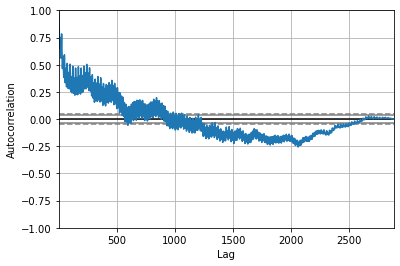

In [7]:
autocorrelation_plot(lim_load_df)

In [8]:
def plot_trend(data):
    plt.figure(figsize=(12,4))
    plt.plot(data)
    plt.title('Hourly Load Data', fontsize=20)
    plt.ylabel('Load', fontsize=16)
    for year in range(start_date.year,end_date.year):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

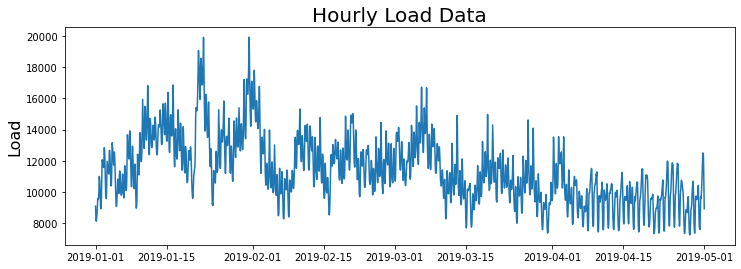

In [9]:
plot_trend(lim_load_df)

In [10]:
ad_fuller_result = adfuller(lim_load_df)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.9450032698069446
p-value: 0.0017275111347011998


<BarContainer object of 20 artists>

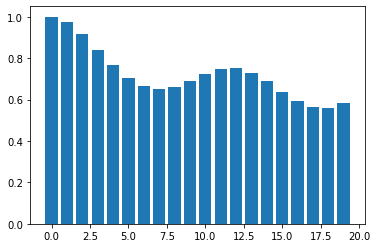

In [11]:
acf_vals = acf(lim_load_df)
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags])

<BarContainer object of 15 artists>

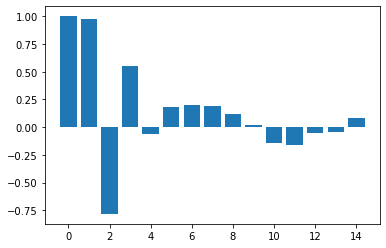

In [12]:
pacf_vals = pacf(lim_load_df)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

In [13]:
lim_load_df

DATE
2019-01-01 00:00:00     9088.0
2019-01-01 01:00:00     8684.0
2019-01-01 02:00:00     8324.0
2019-01-01 03:00:00     8165.0
2019-01-01 04:00:00     8127.0
                        ...   
2019-04-30 20:00:00    12398.0
2019-04-30 21:00:00    11758.0
2019-04-30 22:00:00    10677.0
2019-04-30 23:00:00     9652.0
2019-05-01 00:00:00     8931.0
Freq: H, Name: MW, Length: 2881, dtype: float64

In [14]:
train_end = datetime(2019, 4, 21)
test_end = datetime(2019, 5, 1)

train_data = lim_load_df[:train_end]
test_data = lim_load_df[train_end + timedelta(days=1):test_end]
test_data

DATE
2019-04-22 00:00:00     7737.0
2019-04-22 01:00:00     7471.0
2019-04-22 02:00:00     7362.0
2019-04-22 03:00:00     7410.0
2019-04-22 04:00:00     7632.0
                        ...   
2019-04-30 20:00:00    12398.0
2019-04-30 21:00:00    11758.0
2019-04-30 22:00:00    10677.0
2019-04-30 23:00:00     9652.0
2019-05-01 00:00:00     8931.0
Freq: H, Name: MW, Length: 217, dtype: float64

In [14]:

model_fit = pm.auto_arima(train_data,
                             max_p=3, max_q=3, 
                             max_P=3, max_Q=3,
                             m=24, seasonal=True,
                             trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

#predictions = model_fit.predict(n_periods=100)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=22.88 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=39940.414, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=inf, Time=9.85 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=36302.719, Time=4.33 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=39938.416, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=37615.647, Time=0.81 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=6.63 sec
 ARIMA(0,1,1)(0,0,2)[24] intercept   : AIC=35743.496, Time=19.78 sec
 ARIMA(0,1,1)(1,0,2)[24] intercept   : AIC=inf, Time=79.70 sec
 ARIMA(0,1,1)(0,0,3)[24] intercept   : AIC=35543.734, Time=57.08 sec
 ARIMA(0,1,1)(1,0,3)[24] intercept   : AIC=inf, Time=88.71 sec
 ARIMA(0,1,0)(0,0,3)[24] intercept   : AIC=37311.403, Time=45.47 sec
 ARIMA(1,1,1)(0,0,3)[24] intercept   : AIC=34875.150, Time=82.53 sec
 ARIMA(1,1,1)(0,0,2)[24] intercept   : AIC=35084.845, Time=33.62 sec
 ARIMA(1,1,1)(1,0,3)[24] in

MemoryError: Unable to allocate 113. MiB for an array with shape (75, 75, 2641) and data type float64

In [192]:
#model = SARIMAX(train_data, order=(3, 0, 1), seasonal_order=(1, 1, 1, 24), enforce_invertibility=False, enforce_stationarity=False)
#model_fit = model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.71168D+00    |proj g|=  1.09765D+00

At iterate    5    f=  6.43574D+00    |proj g|=  1.34012D-01

At iterate   10    f=  6.38062D+00    |proj g|=  5.13784D-01

At iterate   15    f=  6.31725D+00    |proj g|=  6.82739D-02

At iterate   20    f=  6.31411D+00    |proj g|=  1.17596D-02

At iterate   25    f=  6.31248D+00    |proj g|=  2.57128D-01

At iterate   30    f=  6.30801D+00    |proj g|=  2.67531D-02

At iterate   35    f=  6.30776D+00    |proj g|=  1.59923D-03

At iterate   40    f=  6.30772D+00    |proj g|=  3.79538D-02

At iterate   45    f=  6.30565D+00    |proj g|=  1.26232D-01


/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.28633D+00    |proj g|=  8.80057D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     66      1     0     0   8.801D-02   6.286D+00
  F =   6.2863343591738134     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [193]:
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                 MW   No. Observations:                 2641
Model:             SARIMAX(3, 0, 1)x(1, 1, 1, 24)   Log Likelihood              -16602.209
Date:                            Mon, 11 Apr 2022   AIC                          33218.418
Time:                                    00:54:15   BIC                          33259.434
Sample:                                01-01-2019   HQIC                         33233.282
                                     - 04-21-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8082      0.068     26.614      0.000       1.675       1.941
ar.L2         -0.9994      0.122   

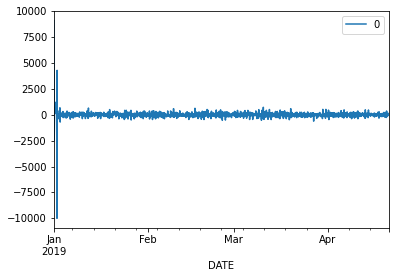

In [194]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

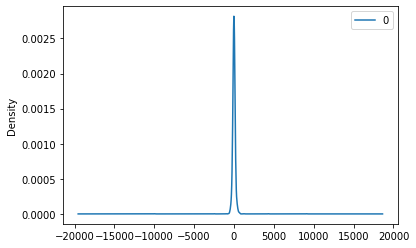

In [195]:
residuals.plot(kind='kde')
plt.show()

In [196]:
print(residuals.describe())

                 0
count  2641.000000
mean      0.819713
std     320.474973
min   -9999.223244
25%     -84.079604
50%      -3.147951
75%      78.959344
max    9088.000000


In [15]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [16]:
len(test_data.index)

217

In [198]:
predictions = model_fit.predict(n_periods=(len(test_data.index)))
residuals = test_data - predictions

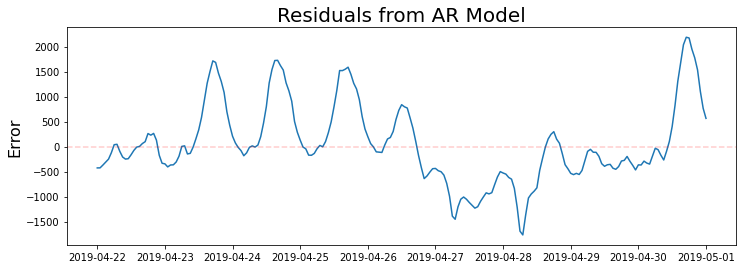

In [199]:
plt.figure(figsize=(12,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

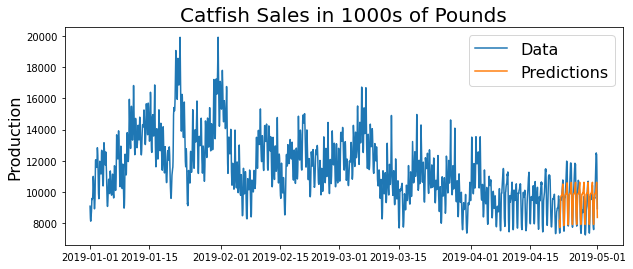

In [200]:
plt.figure(figsize=(10,4))

plt.plot(lim_load_df)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [201]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0598


In [202]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 788.0869081402116


In [209]:
test_data = pd.DataFrame(data = test_data)
test_data['pred'] = predictions
test_data['MAPE'] = (test_data['MW'] - test_data['pred']) / test_data['MW']

,MW,pred,MAPE
DATE,,,
2019-04-22 00:00:00,7737.0,8164.412326,-0.055243
2019-04-22 01:00:00,7471.0,7897.253244,-0.057054
2019-04-22 02:00:00,7362.0,7732.367415,-0.050308
2019-04-22 03:00:00,7410.0,7720.865832,-0.041952
2019-04-22 04:00:00,7632.0,7883.413182,-0.032942
2019-04-22 05:00:00,8227.0,8351.016634,-0.015074
2019-04-22 06:00:00,9100.0,9063.154811,0.004049
2019-04-22 07:00:00,9537.0,9491.718371,0.004748
2019-04-22 08:00:00,9553.0,9649.133302,-0.010063


In [211]:
one_day = test_data[:24]
print('1-day ahead Mean Absolute Percent Error:', round(np.mean(one_day['MAPE']),4))

1-day ahead Mean Absolute Percent Error: -0.013


In [213]:
two_day = test_data[:48]
print('2-day ahead Mean Absolute Percent Error:', round(np.mean(two_day['MAPE']),4))

2-day ahead Mean Absolute Percent Error: 0.0116
